<a href="https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/2025/Guidance_for_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Where You Want:
## Understanding Test-Time Guidance for Latent Flow Models

*by "Flo Gida" aka Scott H. Hawley [@drscotthawley](https://bsky.app/profile/drscotthawley.bsky.social), Oct. 2025*

> *"When we put bits into the mouths of horses to make them obey us, we can turn the whole animal. Or take ships as an example. Although they are so large and are driven by strong winds, they are steered by a very small rudder wherever the pilot wants to go."*
><br> -- James 3:3-4 (NIV)

In this tutorial, we'll learn about inference-time "plugin" applications for flow matching generative models such as FLUX or Stable Audio Open Small. Unlike "classifier free guidance" (CFG), which requires the model to be trained with the conditioning signal (i.e. input to control the model's behavior) you may be interested in, (general) guidance can apply inference-time conditioning that works even with models that were not trained with the specific conditioning you're interested in.

We'll look at two applications:

1. Classifier Guidance
2. Inpainting


Our focus will be on ***latent space*** models,  since most modern generative models operate in latent space.

This lesson assumes familiarity with flow-based generative models. See the ICLR 2025 blog post ["Flow With What You Know"](https://iclr-blogposts.github.io/2025/blog/flow-with-what-you-know/) for an overview.


# I. The General Picture
Intuitively, guidance amounts to "steering" during the integration of the flow model in order to end up at a desired end point.  The [following video](https://bsky.app/profile/drscotthawley.bsky.social/post/3m3df2idqrc2g) provides a useful metaphor:  

In [ ]:
# @title
%%HTML
<blockquote class="bluesky-embed" data-bluesky-uri="at://did:plc:sw457c7pedt3n57ci6qlrws6/app.bsky.feed.post/3m3df2idqrc2g" data-bluesky-cid="bafyreig53ufqtdsyf6np5xhoc75wdbd7pwlgxwbqeg4gatq5atvigdk54e" data-bluesky-embed-color-mode="system"><p lang="en">Been working on a tutorial on Guidance for (latent) flow-based generative models, and happened upon a great metaphor today while taking a little &quot;me&quot; time. :-)<br><br><a href="https://bsky.app/profile/did:plc:sw457c7pedt3n57ci6qlrws6/post/3m3df2idqrc2g?ref_src=embed">[image or embed]</a></p>&mdash; Scott H. Hawley (<a href="https://bsky.app/profile/did:plc:sw457c7pedt3n57ci6qlrws6?ref_src=embed">@drscotthawley.bsky.social</a>) <a href="https://bsky.app/profile/did:plc:sw457c7pedt3n57ci6qlrws6/post/3m3df2idqrc2g?ref_src=embed">Oct 16, 2025 at 1:26 PM</a></blockquote><script async src="https://embed.bsky.app/static/embed.js" charset="utf-8"></script>

Ok, the analogy's not quite right: you can't just steer, you are going to have to paddle a little bit.  In other words, you're going to have to provide a bit of a *extra velocity* to correct the where the "current" flow is taking you.

In flow matching, we go from a source data (distribution) at time $t=0$ to target
data at $t=1$.  Since this tutorial applies to latent space, we'll use the letter $ z $ for position, such as $z_t$ being the position at time $t$.

When you're "looking ahead" to estimate where you'll end up, you project linearly along the current velocity $ \vec{v_t}$ for a duration of the remaining time. Let's call this estimate $\widehat{z_1} $, your projected endpoint :

$$ \widehat{z_1} = z_t + (1-t)\vec{v_t}\tag{1} $$

...but perhaps that's not where you want to go. Where you want to go is a distance $\Delta \widehat{z_1} $ from $ \widehat{z_1} $, and to get there you'll have to make a"course correction" $ \Delta \hat{v} $, as shown in the following diagram:  

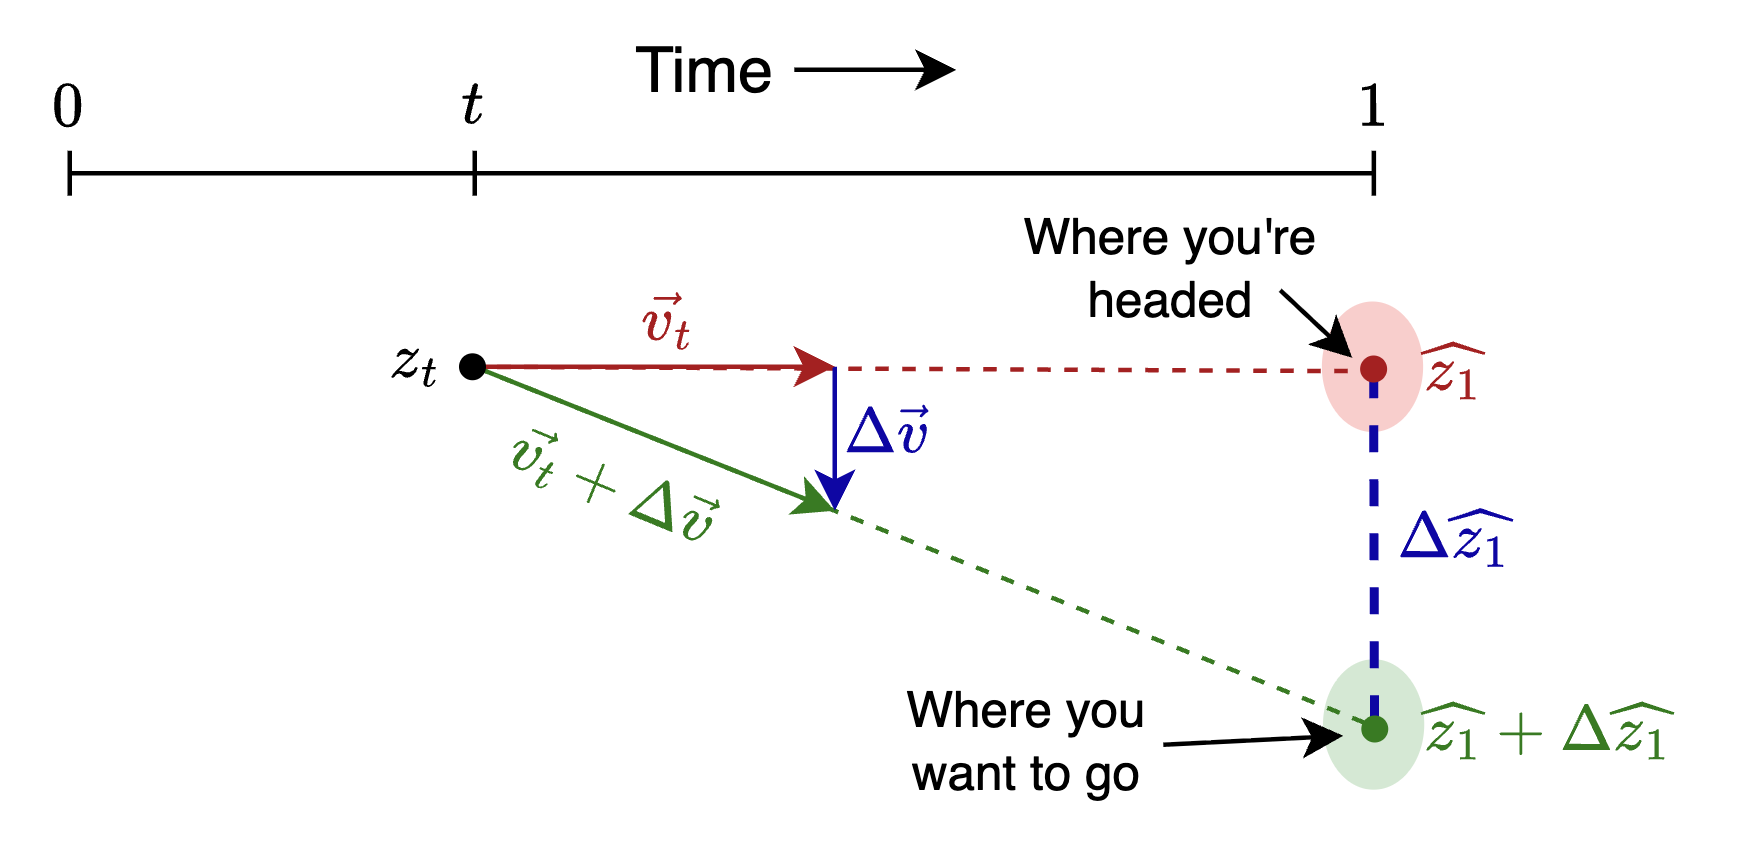


By similar triangles, $ \Delta \widehat{z_1} = (1-t)\Delta \vec{v} $, which means the course correction you want is

$$ \Delta \vec{v} = { \Delta \widehat{z_1} \over 1-t }.$$

*Since you're going to more math once you try to read the scholarly literature on these topics, let's go a bit further into the math...*

So $ \Delta \widehat{z_1} $ is a measure of the *deviation* from the desired endpoint. Now, in practical application we won't actually use the "distance" $ \Delta \widehat{z_1} $, but we'll use something that functions *like* a distance, such as a K-L divergence or Mean Squared Error (MSE), which are familiar loss functions from neural network training.

When doing inference, this deviation serves the same function as a "loss" does when training models something we will seek to minimize -- via gradient descent! -- except we'll vary the flow positions $ z $ instead of the model weights.  More specifically, we'll consider the "likelihood"
 $ p( \widehat{z_1} | y ) $ of getting a $z_1$ that matches a given control $ y $, and we'll seek to maximize that likelihood, or equivalently to *minimize the negative* log-likelihood.

 The expression $ -\nabla_{\widehat{z_1}} \log p( \widehat{z_1} | y ) $ essentially answers the question, "in which direction should I adjust $ \widehat{z_1} $ so as to make
  $ p( \widehat{z_1} | y ) $ more likely? Just like with gradient descent when training a network,
  this gives us a direction and a magnitude, which we then multiply by a ~~learning rate~~ "guidance
  strength" $ \eta $ to turn it into a step size.

  So our final expression for $ \Delta v $ will involve replacing $ \Delta \widehat{z_1} $ in (2) with
  $ - \eta \nabla_{\widehat{z_1}} \log p( \widehat{z_1} | y ) $:

$$ \Delta \vec{v} =  - \eta \gamma_t \nabla_{z_t} \log p( \widehat{z_1} | y )  \tag{3} $$

where $\gamma_t = 1 / (1-t)$, and we used the fact that $ \nabla_{\widehat{z_1}} = \nabla_{z_t} $ (since
$ \widehat{z_1} \propto z_t $ ).

The factor of $\gamma_t = 1/ (1-t) $ determines how the size of our course correction scales with time. It implies that we can make small course corrections at early times, but comparable corrections at later times require larger adjustments. As we will see later, this is not the only time scale we can choose, but it will suffice for now.

 It's best at this point if we move to a concrete example; let's use guidance to add some class conditioning to an *unconditional* generative model by having a separate classifier inspect our estimated outputs. In this case $ \log p( \widehat{z_1} | y ) $  will be the (logits form of the) Cross-Entropy Loss, where $ y $ are the desired class outcomes.

# II. Classifier Guidance

If we want our model to generate a member of a particular class, we can use an external classifier to examine the generated samples. The constraint to minimize will be the difference between the desired class and the `argmax` of the classifier output (or some similar relationship that enforces the class compliance).

For our flow model, let's use [Marco Cassar's winning submission](https://github.com/Ocrabit/dl_class_projects/blob/main/dl_experimentation/submissions/marco_submission.py) from the [2025 DLAIE Leaderboard Contest](https://2025-dlaie-leaderboard.streamlit.app/) on unconditional latent flow matching of MNIST digits.  For the classifier, we'll use the [official evaluation classifier](https://github.com/DLAIE/2025-LeaderboardContest/blob/main/evaluate_submission.py) from the same contest.

## Set Up the Flow Model and Classifier

In [ ]:
# Get some dependencies
import os
os.environ['PATH'] = f"/app/data/.local/bin:{os.environ['PATH']}"
!pip install -q torch==2.8.0 torchvision==0.23.0
!pip install -q safetensors gdown wandb

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")
import os
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

In [ ]:
# Set some info about what platform we're running on.
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print("device =",device)

platform = 'local'
dir_prefix = './'

device = cuda


In [ ]:
# Get Marco's VAE and Flow model(s)
!wget -q --no-clobber=off https://raw.githubusercontent.com/Ocrabit/dl_class_projects/refs/heads/main/dl_experimentation/submissions/marco_submission.py

from marco_submission import SubmissionInterface, integrate_path, rk4_step

sub = SubmissionInterface().to(device)

Downloading...
From: https://drive.google.com/uc?id=1rP6yP5yixCI1M7LOrv9v9vJkeYkXnptG
To: /content/downloaded_vae.safetensors
100%|██████████| 660k/660k [00:00<00:00, 8.46MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pAU4p6xQMDgAuywu-go-5iM4qPDXgJFc
To: /content/downloaded_flow.safetensors
100%|██████████| 42.6k/42.6k [00:00<00:00, 60.0MB/s]


In [ ]:
# generate some samples
n_samples = 10
x1 = sub.generate_samples(n_samples=n_samples)
x1.shape

torch.Size([10, 28, 28])

Let's draw those generated images.

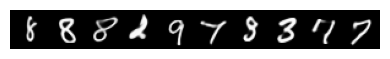

In [ ]:
# @title show_grid() display code
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_grid(x1):
    if len(x1.shape) == 3: x1 = x1.unsqueeze(1)  # add channels dim
    grid = make_grid(x1, nrow=10, padding=2, normalize=False)
    plt.figure(figsize=(4, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_grid(x1)

Now let's setup the (pretrained) classifier we'll use for the guidance:

In [ ]:
# Get the evaluation classifier
!wget -q --no-clobber=off https://raw.githubusercontent.com/DLAIE/2025-LeaderboardContest/refs/heads/main/evaluate_submission.py

from evaluate_submission import setup_resnet

classifier = setup_resnet().to(device).eval()

#@torch.no_grad()  <--- Don't do this here! We'll use classifier gradients for guidance later
def classify(classifier, x, use_argmax=False):
    if len(x.shape) == 3: x = x.unsqueeze(1)  # add channels dim
    logits = classifier(x)
    probs = F.softmax(logits, dim=1)
    return torch.argmax(probs, dim=1) if use_argmax else (logits, probs)

# test the classifer
with torch.no_grad():
    logits, probs = classify(classifier, x1)
    print(logits.shape, probs.shape)
    pred_class = classify(classifier, x1, use_argmax=True)
    print(pred_class.cpu())

Downloading...
From: https://drive.google.com/uc?id=1kW_wnq-J_41_ESyQUX1PJD9-vvbWbCQ8
To: /content/downloaded_resnet.safetensors
100%|██████████| 6.28M/6.28M [00:00<00:00, 30.0MB/s]


torch.Size([10, 10]) torch.Size([10, 10])
tensor([8, 8, 8, 1, 9, 7, 8, 3, 1, 7])


Let's make a plot showing the classifier's output probabilities (aka likelihoods) across all classes, for all 10 samples. The samples will be the rows, and the class-likelihoods outputs from the classifier will be the columns, where brightness is correlated with likelihood.

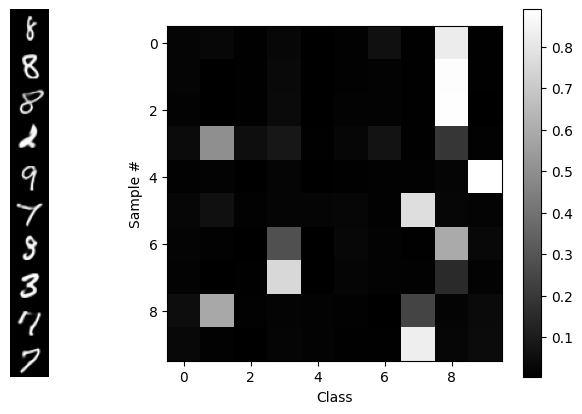

In [ ]:
# @title `show_probs` viz routine
def show_probs(probs, x=None):
    """show probs as colormap intensities via imshow.
    have each row be a sample and each column be a class probability"""
    ncols = 1 if x is None else 2
    fig, axs = plt.subplots(1, ncols, figsize=(8, 4))
    if ncols == 1: axs = [axs]

    if x is not None:  # show a little version of the x image for each row
        axs[0].imshow(make_grid(x.unsqueeze(1).cpu(), nrow=1, padding=2, normalize=False).permute(1, 2, 0).cpu(), cmap='gray')
        axs[0].axis('off')

    # show probabilities as an intensity map
    im = axs[ncols-1].imshow(probs.cpu(), cmap='gray')
    axs[ncols-1].set_xlabel("Class")
    axs[ncols-1].set_ylabel("Sample #")
    plt.colorbar(im, ax=axs[ncols-1])
    plt.tight_layout()

show_probs(probs, x=x1)

...So we see that this is an *unconditional* generative model: there's nothing determining the classes of the outputs -- until we add guidance, below! ;-)   In a short while, we'll reproduce that diagram, but we'll use guidance to get one class per sample, in order, along the diagonal.

To do that, we're going to have to "break open" the `generate_samples` routine and even the `integrate_path` routine to allow us to *add a correction* to the velocity $ v_t $ generated by the flow model at time $ t $.  That correction $ \Delta v $  will be based on the classifier's output using the *projected estimate* $ \widehat{x_1} $ of the final data, which we'll obtain via *linear extrapolation*.  

In our latent space model, we flow with latents $z$ which must be *decoded* using the VAE's decoder $ \mathscr{D} $ :

$$ \widehat{z_1} = z_t + (1-t) v_t $$
$$ \widehat{x_1} = \mathscr{D}(\widehat{z_1}) $$

The correction $ \Delta v $  will generated from a constraint which in this case is just like regular "classifier loss" function in a supervised learning problem. The desired class label is the "target" and the classifier output of the projected estimate is the "prediction".


Our code will follow this general layout:  

```python
loss_fn = torch.nn.CrossEntropyLoss()

v_t = flow_model(z_t, t)
z1_hat = z_t + (1-t)*v_t               # projected destination
x1_hat = sub.vae.decoder(z1_hat)       # decode it to pixel space
probs = classify(classifier, x1_hat)   # classifer operates in pixel space
loss = loss_fn(probs, target)          # "supervised learning"
delta_v = magic_function(loss,...???)  # <--- here's the part we need to work out
v_t = v_t + delta_v * guidance_strength  # we can set the strength of the correction
```

So what magic function will turn that `loss` into a *velocity*? Well, we can turn to good old Gradient Descent!  Except instead of taking the gradient with respect to the model weights like we used to, we're going to take the gradient with respect to the flow coordinates $ z $  in the latent space, thereby generating a vector in the latent space.

The insight is that PyTorch lets us compute the gradient with respect to anything. We just need to tell it what we want. And we need to be careful to make sure that the VAE and flow models stay frozen, so the only thing that's allowed to change are the latents $ z $.

The cleanest way to pull this off, code-wise, is to create a function called `compute_v()` which for starters will just call the flow model, but then we'll add to it with guidance info:

In [ ]:
# wherever we used to just call flow_model(), we'll now call compute_v() instead
@torch.no_grad()
def compute_v(flow_model, z, t, guidance_dict=None, **kwargs):
    v_t = flow_model(z, t)
    if guidance_dict is not None:
        v_t += compute_dv(v_t, z, t, guidance_dict, **kwargs)
    return v_t

@torch.enable_grad()  # <-- later, this will be a key for getting guidance
def compute_dv(v_t, z, t, g:dict, **kwargs):
    "placeholder for now, will add guidance math later"
    return torch.zeros_like(v_t).detach() # no correction yet; no gradients returned

We'll to use our usual "boilerplate" flow integration code, except we'll add "`**kwargs`" everywhere so we can pass controls "all the way in" to the `compute_dv()` guidance routine, and pair `flow_model()` as an arg to `compute_v()` via `functools.partial`.

In [ ]:
# @title flow integration routines, slightly modified from "flow with what you know" blog

from functools import partial  # use partial to package flow_model with compute_v

@torch.no_grad()
def rk4_step(f, y, t, dt, **kwargs):  # regular rk4, + kwargs passthrough
    # f: callable (y, t) -> dy/dt
    k1 = f(y, t, **kwargs)
    k2 = f(y + 0.5 * dt * k1, t + 0.5 * dt, **kwargs)
    k3 = f(y + 0.5 * dt * k2, t + 0.5 * dt, **kwargs)
    k4 = f(y + dt * k3, t + dt, **kwargs)
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

@torch.no_grad()
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle.
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s < 0 or s > 1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4 * (1 - s) * t ** 3 + 6 * (s - 1) * t ** 2 + (3 - 2 * s) * t
    if dt:  # warped time-step requested; use derivative
        return tw, dt * 12 * (1 - s) * t ** 2 + 12 * (s - 1) * t + (3 - 2 * s)
    return tw


@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=100, warp_fn=None, latent_2d=False, prog_bar=True, t0=0, **kwargs):
    p = next(model.parameters())
    device, model_dtype = p.device, p.dtype
    current_points = initial_points.to(device=device, dtype=model_dtype).clone()
    model.eval()
    ts = torch.linspace(t0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn: ts = warp_fn(ts)
    if latent_2d: t_batch = torch.empty((current_points.shape[0], 1), device=device, dtype=model_dtype)
    vel_model = partial(compute_v, model)  # here's the secret sauce
    iterator = range(len(ts) - 1)
    if prog_bar: iterator = tqdm(iterator, desc="Integrating Path")
    for i in iterator:
        t, dt = ts[i], ts[i + 1] - ts[i]
        if latent_2d: t = t_batch.fill_(t.item())
        current_points = step_fn(vel_model, current_points, t, dt, **kwargs)
    return current_points

def generate_samples(sub, n_samples: int, n_steps=15, z0=None, t0=0, **kwargs) -> torch.Tensor:
    z0 = torch.randn([n_samples, sub.latent_dim]).to(sub.device) if z0 is None else z0
    z1 = integrate_path(sub.flow_model, z0, n_steps=n_steps, step_fn=rk4_step, t0=t0, **kwargs)
    gen_xhat = F.sigmoid(sub.decode(z1).view(-1, 28, 28))
    return gen_xhat


In [ ]:
# quick no-guidance test with this newer code:
x1 = generate_samples(sub,n_samples=10) # , guidance_dict="Coming up next")
x1.shape

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

torch.Size([10, 28, 28])

Now that we know that works, let's "supe up" `compute_dv()` to include the guidance correction.  We'll use the `torch.autograd.grad()` function to compute the gradient of the loss.  
First we have the `guidance_dict` that we'll use to pass through our intentions through the various layers of routines to get to `compute_dv()`:  

In [ ]:
guidance_dict ={'classifier': classifier,     # the classifier model to use
                'decode': sub.decode,         # how to decode to pixel space for classifier
                'loss_fn': torch.nn.CrossEntropyLoss(reduction='none'), # don't sum over batch dim
                'target': torch.arange(10).to(device),  # desired class outcomes
                'strength': 5.0,              # "guidance strength", you may vary this
                't_min': 0.01, 't_max': 0.99, # t range to apply guidance, may vary these
               }

Next we have the fully-equipped `compute_dv()`. This code is overly-commented to make it easy to follow each step.  (We replaced `guidance_dict` with `g` locally for brevity.)  No other changes to any preceding code are necessary. We'll be ready to do guided inference after this definition!

In [ ]:
@torch.enable_grad()  # <-- Needed to compute gradients if calling code has @torch.no_grad()
def compute_dv(v_t, z, t, g:dict, eps=1e-6, debug=False):
    "Compute the guidance correction to the flow velocity"
    if t < g['t_min'] or t > g['t_max']: return torch.zeros_like(v_t).detach()
    z.requires_grad_(True)                   # need to enable gradient tracking for z
    z1_hat = z + (1 - t) * v_t               # linear projection to estimated endpoint

    # Decoding to pixel space (if decoder provided)
    x1_hat = z1_hat if g['decode'] is None else F.sigmoid(g['decode'](z1_hat)).view(-1, 28, 28)

    logits, probs = classify(g['classifier'], x1_hat)          # run classifier
    loss = g['loss_fn'](logits, g['target'][:len(logits)])     # loss <-> "negative log likelihood"

    # Compute grad wrt z. "grad_outputs=": don't sum over over batch, keep unique to each datum
    grad_z = torch.autograd.grad(loss, z, grad_outputs=torch.ones_like(loss), retain_graph=False)[0]
    dv = -grad_z / (1 - t + eps)   # - minimizes, (1-t) makes it velocity, eps helps stability

    z.requires_grad_(False)        # cleanup (z is a tensor so local changes could propagate)
    return g['strength'] * dv.detach()  # detach so no gradients returned

Let's go!

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

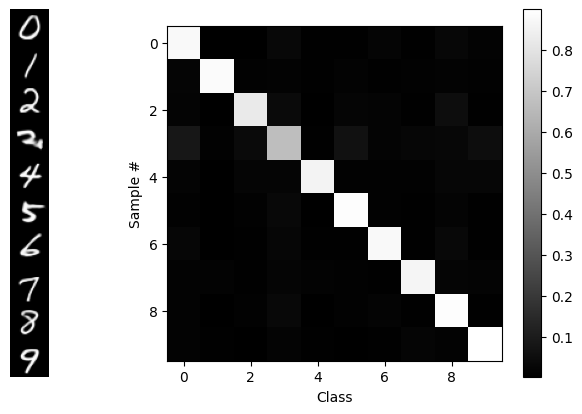

In [ ]:
torch.manual_seed(0) # for reproducibility as we change other things
with torch.no_grad():
   x1 = generate_samples(sub, n_samples=10, guidance_dict=guidance_dict, debug=False)
   logits, probs = classify(classifier, x1)
show_probs(probs, x=x1)

BLAM! Our desired goal: in order, along the diagonal. We see that guidance isn't perfect, but that's partially a function of the VAE and the flow model too.  

To get a better survey of the capabilities, let's make a 10x10 grid of outputs with classes along each column:

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

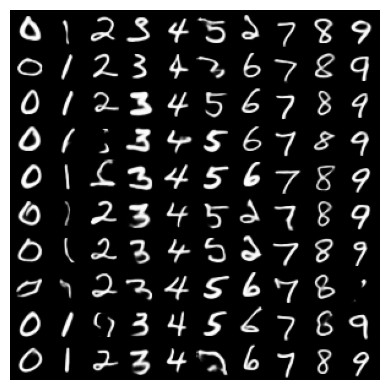

In [ ]:
target = torch.arange(10).repeat(10).to(device) #  [0,1,2,..9, 0,1,2,..9, ...]
guidance_dict['target'] = target
torch.manual_seed(42)         # (optional) for reproducibility
x1 = generate_samples(sub, n_samples=len(target), guidance_dict=guidance_dict)
show_grid(x1)

That worked fine, but if you run it on a CPU, it's painfully slow. So instead, let's...

## Train a Latent Classifier
We'll train a model `z_classifier` that looks only in latent space, so we can use it as a guidance signal.

In [ ]:
# @title Encode MNIST to latents & save to file
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

@torch.no_grad()
def encode_dataset(vae, dataset, batch_size=512):
    """Encode entire dataset into VAE latents (z = mu)"""
    device = next(vae.parameters()).device
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_latents, all_labels = [], []
    must_flatten = None
    with torch.no_grad():
        for data, labels in tqdm(loader):
            x = data.to(device)
            # next bit is so it should work with linear layers or conv
            if must_flatten is None or must_flatten==False:
                try:
                    z = vae.encoder(x)
                except RuntimeError:
                    z = vae.encoder(x.view(x.size(0), -1))
                    must_flatten = True
            else: z = vae.encoder(x.view(x.size(0), -1))
            mu, logvar = z
            all_latents.append(mu.cpu())
            all_labels.append(labels)
    return torch.cat(all_latents), torch.cat(all_labels)


def encode_mnist(vae, filename=None, batch_size=512):
    print("Acquiring train & test MNIST image datasets...")
    train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
    test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())

    print(f"\nEncoding dataset to latents...")
    train_latents, train_labels = encode_dataset(vae, train_ds, batch_size=batch_size)
    test_latents, test_labels = encode_dataset(vae, test_ds, batch_size=batch_size)

    if filename is not None:
        print(f"Saving to {filename} ...")
        torch.save({ 'train_z': train_latents,     'test_z': test_latents,
                     'train_labels': train_labels, 'test_labels': test_labels }, filename)
    return train_latents, train_labels


# Encode the dataset
latent_data_filename = 'mnist_latents.pt'
if not os.path.exists(latent_data_filename):
    if platform != 'solveit':
        train_latents, train_labels = encode_mnist(sub.vae, filename=latent_data_filename)
    else:
        import threading
        thread = threading.Thread(target=encode_mnist, args=(sub.vae, latent_data_filename))
        thread.start()

Acquiring train & test MNIST image datasets...


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


Encoding dataset to latents...


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Saving to mnist_latents.pt ...


In [ ]:
# @title `load_encoded_data` from file
def load_encoded_data(filename):
    if 'MyDrive' in filename:
        from google.colab import drive
        drive.mount('/content/drive')
    data_dict = torch.load(filename, weights_only=True)
    return data_dict

data_dict = load_encoded_data(latent_data_filename)
train_z, test_z = data_dict['train_z'], data_dict['test_z']
train_z.shape, test_z.shape

# Create datasets from the latent tensors
train_latent_ds = TensorDataset(train_z, data_dict['train_labels'][:train_z.shape[0]])
test_latent_ds = TensorDataset(test_z, data_dict['test_labels'])

batch_size = 512
train_latent_dl = DataLoader(train_latent_ds, batch_size=batch_size, shuffle=True)
test_latent_dl = DataLoader(test_latent_ds, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_latent_dl)}, Test batches: {len(test_latent_dl)}")
# print single latent size
print(f"Latent size: {train_latent_ds[0][0].shape}")



Train batches: 118, Test batches: 20
Latent size: torch.Size([16])


In [ ]:
# Very simple classifier in latent space
from torch import nn

class LatentClassNet(nn.Module):
    def __init__(self, latent_dim=16, hidden_dim=32, n_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, n_classes)
    def forward(self, z):
        z = F.leaky_relu(self.fc1(z))
        z = F.leaky_relu(self.fc2(z))
        z = F.leaky_relu(self.fc3(z))
        z = F.leaky_relu(self.fc4(z))
        return z

z_classifier = LatentClassNet().to(device)

In [ ]:
# @title Latent classifier trianing loop
epochs, lr = 10, 1e-3

model = z_classifier
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
for epoch in range(epochs):
    model.train()
    #pbar = tqdm(train_latent_dl)
    for i, (latents, labels) in enumerate(train_latent_dl):
        optimizer.zero_grad()
        latents, labels = latents.to(device), labels.to(device)
        logits = z_classifier(latents)
        loss = criterion(logits, labels)
        #pbar.set_postfix({'train_loss': loss.item()})
        if i % 3 == 0: print("=",end="") # simple progress bar
        loss.backward()
        optimizer.step()

    model.eval()
    val_latents, val_labels = next(iter(test_latent_dl)) # might need to reset sometimes
    val_latents, val_labels = val_latents.to(device), val_labels.to(device)
    val_logits = model(val_latents)
    val_loss = criterion(val_logits, val_labels)
    val_acc = (val_logits.argmax(dim=1) == val_labels).float().mean()
    print(f"| Epoch {epoch+1}: val_loss={val_loss.item():.4f}, val_acc={val_acc.item():.4f}")

========================================| Epoch 1: val_loss=1.1540, val_acc=0.6758
========================================| Epoch 2: val_loss=0.2064, val_acc=0.9395
========================================| Epoch 3: val_loss=0.1129, val_acc=0.9590
========================================| Epoch 4: val_loss=0.0876, val_acc=0.9746
========================================| Epoch 5: val_loss=0.0836, val_acc=0.9727
========================================| Epoch 6: val_loss=0.0731, val_acc=0.9727
========================================| Epoch 7: val_loss=0.0722, val_acc=0.9746
========================================| Epoch 8: val_loss=0.0684, val_acc=0.9746
========================================| Epoch 9: val_loss=0.0667, val_acc=0.9727
========================================| Epoch 10: val_loss=0.0657, val_acc=0.9766


Let's test our newly-trained latent classifier to make sure it works before trying to use it for guidance.

z.shape =  torch.Size([10, 16])
Labels:  tensor([9, 6, 6, 5, 4, 0, 7, 4, 0, 1]) 



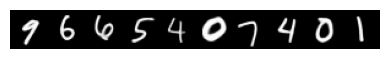


logits.shape = torch.Size([10, 10])
probs.shape  = torch.Size([10, 10])
Classes: tensor([9, 6, 6, 5, 4, 0, 7, 4, 0, 1])


In [ ]:
# Get some some data
z, L = test_latent_ds[20:30]
z = z.to(device)
x = F.sigmoid(sub.decode(z)).view(-1,28,28)
print("z.shape = ",z.shape)
print("Labels: ",L,"\n")
show_grid(x.squeeze())

# run the z_classifier
with torch.no_grad():
    logits, probs = classify(z_classifier, z)
    print(f"\nlogits.shape = {logits.shape}\nprobs.shape  = {probs.shape}")
    pred_class = classify(z_classifier, z, use_argmax=True)
    print("Classes:", pred_class.cpu())

Looks pretty good.  Moving on to...

## Latents-Only Gudiance!

Now that we have a trained classifier that operates in latent space, we can run basically the same code as before, only it will execute wayyyyy faster. :)

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

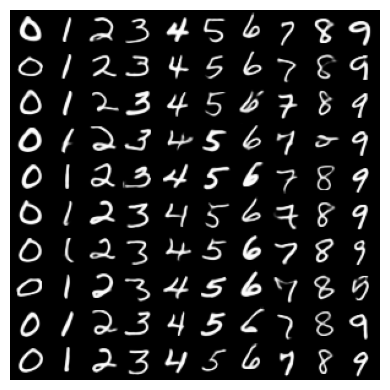

In [ ]:
guidance_dict ={'classifier': z_classifier,
                'decode': None,    # no decoding, latent space only
                'loss_fn': torch.nn.CrossEntropyLoss(reduction='none'), # don't sum across batch dim
                'target': torch.arange(10).repeat(10).to(device),
                'strength': 5.0,   # "guidance strength"
                't_min': 0.01,  't_max': 0.99, }


torch.manual_seed(42) # remove for new samples each time
x1 = generate_samples(sub, n_samples=len(guidance_dict['target']), guidance_dict=guidance_dict)
show_grid(x1)

Was that fast or WHAT?! 🚀

Since we no longer have to propagate gradients through the much larger VAE decoder model and pixel-space classifer, we can get answers a lot faster via our small latents-only classifier.

Let's move on to another application of guidance, for which our guidance signal doesn't depend on a separate trained (classifier) model at all: inpainting.

# III. Inpainting

When inpainting, we have some "mask" inside which some of the data have been removed, and we want to use the model to fill in the missing part in a way that matches with the surrounding pixels. Let's take a look at an example from MNIST, where we show an original image, the mask and the masked-out image:

Original Image  |    Mask    |  Masked Image


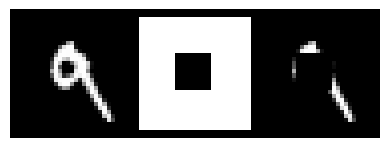

In [ ]:
# @title
#@ Demo what inpainting looks like
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
x = test_ds[7][0]
H, W = x.shape[-2:]
M = torch.ones([H,W], dtype=x.dtype, device=x.device)   # 1 = keep pixels
M[H//3:2*H//3, W//3:2*W//3] = 0                         # 0 = mask out
x_masked = M*x
print("Original Image  |    Mask    |  Masked Image")
show_grid( torch.cat([x, M.unsqueeze(0), x_masked],dim=0) )

Another example would be a picture of a face where you've blocked out the nose and you want the model to fill in a nose.

Now, some of the "filling in" you can get "for free" because the model has only been exposed to data that satisfies the manifold or probability distribution of the training data -- e.g. If it was trained on faces, then it only ever saw faces with noses and hence can only generate faces with noses -- but the real trick is to do it "well" and have it be "good" in the end. ;-)

There's a wealth of information on guidance as it was originally applied to diffusion models.
Sander Dieleman's blog post, ["Guidance: a cheat code for diffusion models"](https://sander.ai/2022/05/26/guidance.html), is a classic and should (eventually) be read by all.  Yet because of the stochastic/random nature of the diffusion path, there are several "complicating" aspects of diffusion guidance that we're going to gloss over in this tutorial because in the case of deterministic, smooth flow-model trajectories, things become a lot more intuitive.

We'll follow a method outlined in the paper ["Training-free Linear Image Inverses via Flows"](https://arxiv.org/abs/2310.04432) by Pokle et al, a methoda that applies to general linear inverse problems of which inpainting is a particular case, and we'll simplify their method to adapt it for *just inpainting.*

The method will be to try to generate an *entire* new image $ x_1 $ that everywhere *outside the mask matches up* with the pixels in user-supplied (masked) image $ y $.  So the constraint will be, given a 2D mask $ M $ (where $ M $=1 means there's an original pixel there, and $ M $=0 is the masked-out region), to require that our estimate image $\widehat{x_1}$ (i.e. the decoded image version of the estimated latets $\widehat{z_1} $   ) satisfies  $ M*\widehat{x_1} = M* y$, or in a "residual form", we'll just compute the Mean Squared Error (MSE) of $ M*(\widehat{x_1}-y) $:

$$ {\rm Constraint:} = M^2 * (\widehat{x_1}-y)^2 $$
(and if we want, we can use the fact that $ M $ being a binary mask means $ M^2 = M $).

If we want to do latent-only inpainting (which will be the fastest), then the same constraint applies just with the simplification $\widehat{x_1} = \widehat{z_1}$

The authors of the paper recommend only doing guidance from t equals 0.2 onward because prior to that, it's hard to make any meaningful estimate.. In fact, they don't even integrate before $ t = 0.2$. They just interpolate between the source and the target data to get their starting point at  $ t = 0.2 $.

To use our constraint in the guidance equation (3) for computing $\Delta v\, $, we'll need to turn our constraint into a likelihood by raising it to an expontential power -- so we get a Gaussian! But the guidance equation includes a logarithm that immediately *undoes* our exponentiation:

$$\Delta v = - {\eta \over 1-t} \nabla_{z_t}\,  
{\color{red}{\text{l̸o̸g̸}\,\text{e̸x̸p̸}}}
\left( M^2 * (\widehat{x_1}-y)^2 \right).$$



The gradient part is
 $$ \nabla_{z_t} M^2 *(\widehat{x_1}-y)^2 = 2M^2*(\widehat{x_1}-y) {\partial \widehat{x_1} \over \partial z_t } $$

If we're inpainting in latent space and not using the decoder for the constraint, then $ {\partial \widehat{x_1} / \partial z_t } = 1 $.  Otherwise that term will require evaluation via PyTorch's `autograd` (=slow).

Our earlier time scaling was $\gamma_t = 1/(1-t) $; turns out that doesn't work very well in practice when it comes to inpainting. Instead, we'll use a different time scaling that delivers good (albeit not perfect) results:  $\gamma_t = (1-t)/t$.  

Thus our full equation for the velocity correction will be:

$$ \Delta \vec{v} = -\eta\, \gamma_t\, M^2 *(\widehat{x_1} - y){\partial\widehat{x_1}\over\partial{z_t}}, \ \ \ \ \ \ \ \ \ \gamma_t = {1-t\over t}$$

where we absorbed the factor of 2 into $\eta $, and the last partial derivitive term can be one if we do latent-only inpainting.

Let's implement this in code, using two different versions of the gradient calculation, depending on whether we can do it all in latent space or if we need to propagate gradients through the decoder:

In [ ]:
@torch.no_grad()  # gradients computed analytically!
def ip_latents_grad(v_t, z, t, g:dict, eps=1e-6, **kwargs):
    "gradients for latent-only inpainting, fast"
    z1_hat = z + (1-t)*v_t
    return g['M_sq'] * (z1_hat - g['y'])  #  x1_hat = z1_hat, dz1_hat/dz_t=1

@torch.enable_grad()
def ip_pixels_grad(v_t, z, t, g:dict, eps=1e-6, **kwargs):
    "gradients for pixel-space inpainting. need to use decoder & track via autograd, = slow"
    z.requires_grad_(True)
    z1_hat = z + (1-t)*v_t
    x1_hat = F.sigmoid(g['decode'](z1_hat)).view(-1,1,28,28) # TODO: un-hard-code img size
    grad_x = g['M_sq'] * (x1_hat - g['y'])
    grad_z = torch.autograd.grad(x1_hat, z, grad_outputs=grad_x,retain_graph=False)[0] # mults grad_x by dx1_hat/dz1_hat
    z.requires_grad_(False)
    return grad_z.detach()  # don't send gradients onward

def t_timescale(t, timescale='mine', **kwargs):
    "our choice for adaptive time sacle"
    if timescale =='simple': return 1/(1-t)                          # our earlier scale; doesn't work
    elif timescale=='pokle': return (1-t)**2 / ((1-t)**2 + t**2)     # from pokle et al; can't get it to work
    elif timescale=='constant': return 4  # or any constant. The 4 is from Pokle et al
    else: return (1-t)/t  # This works pretty well! strong guidance at start -> zero at end

def compute_dv_inpainting(v_t, z, t, g:dict, **kwargs):
    "wrapper to call appropriate gradient-computation routine"
    if t < g['t_min'] or t > g['t_max']: return torch.zeros_like(v_t)
    grad_fn = ip_latents_grad if g['decode'] is None else ip_pixels_grad
    grad = grad_fn(v_t, z, t, g, **kwargs)
    dv = -g['strength'] * t_timescale(t, **kwargs) * grad
    return dv.detach()

## Do the Inpainting!

Start with masked images $ y $...

torch.Size([50, 1, 28, 28])


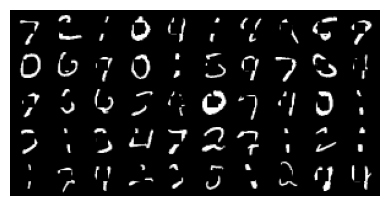

In [ ]:
# setup the data
y = torch.stack([test_ds[i][0] for i in range(50)])
print(y.shape)
y = M*y
show_grid(y.squeeze())

And now we run the inpainting code

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

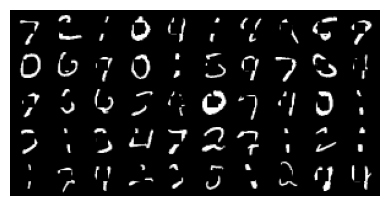

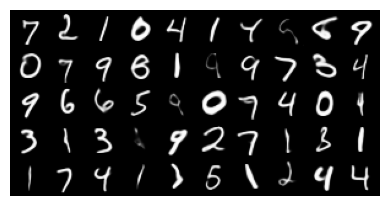

In [ ]:
compute_dv = compute_dv_inpainting  # register our new guidance routine

inpainting_dict ={'decode': sub.decode,         # how to decode to pixel space for classifier
                'M_sq': (M**2).to(device),
                'y': y.to(device),
                'strength': 1.0,              # "guidance strength", you may vary this
                't_min': 0.2, 't_max': 0.999, # t range to apply guidance, may vary these
               }

with torch.no_grad():
    torch.manual_seed(0) # for reproducibility as we change other things
    t0 = 0.2             # starting time as per Pokle et al
    z0 = torch.randn([len(y), sub.latent_dim]).to(sub.device)
    zy = sub.encode(y.to(device))   # encoded version of masked image
    z0 = z0 * (1-t0) + zy * t0      # interpolation init
    inpainting_dict['t_min'] = t0
    x1 = generate_samples(sub, n_samples=len(y), t0=t0, z0=z0, guidance_dict=inpainting_dict, warp_fn=None, debug=False)
    #x1 = torch.where(M>0.9, y.squeeze(), x1)  # force no changes from y, wherever mask M=1

 # show pre- and post-inpainting
show_grid(y.squeeze())
show_grid(x1)

We see that the generated images generally look great, although in some cases, the in-painting code has changed pixels even where the mask is 1. We can disallow this by just resetting those values to the pixels in $ y $.

Turning up the guidance strength would also enforce our constraint better, but turning up too high causes the whole thing to diverge and we get garbage out.

In order to experiment with other methods more easily, we should do inpainting only in latent space, and for that we will need a model that supports spatial latents...

## Latent-Only Inpatining

For this we will switch to a model that uses 7x7 latents that look like smaller versions of the full images.

For our mask, we will simply shrink the pixel-size mask to the size of the latents.


In [ ]:
# Get Spatial VAE & FLow Dit Model
!wget -q --no-clobber=off https://raw.githubusercontent.com/dlaieburner/2025-leaderboard/refs/heads/main/sample_submission_dit.py

try:
    del SubmissionInterface # remove Marco's from earlier; make it reload
except NameError:
    pass  # nevermind

from sample_submission_dit import SubmissionInterface

sub = SubmissionInterface().to(device)

device = cuda


Downloading...
From: https://drive.google.com/uc?id=1kPK3ZPadOUEfH8ZycrG3k27pl9-lGUeL
To: /content/downloaded_vae.safetensors
100%|██████████| 12.6M/12.6M [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q9Iguf--2_MqUjsosS7iAGGzYtVfJ3UF
To: /content/downloaded_flow.safetensors
100%|██████████| 34.1M/34.1M [00:00<00:00, 53.9MB/s]


Let's take a look at the images and their spatial-latent representations:

Images:


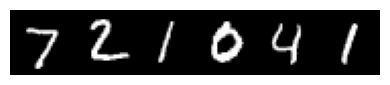

Latents:


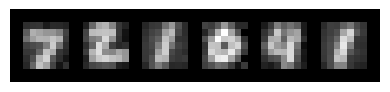

In [ ]:
# @title viz images and spatial latents
from torchvision.datasets import MNIST
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())

x = torch.stack([test_ds[i][0] for i in range(6)])
if len(x.shape) < 4: x1 = x.unsqueeze(1)
print("Images:")
show_grid(x)
z1 = sub.encode(x)
print("Latents:")
show_grid((z1-z1.min())/(z1.max()-z1.min()))

Mask:


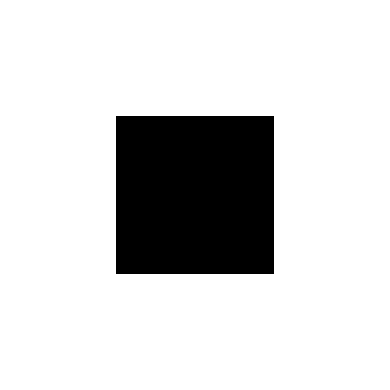

Latent y's:


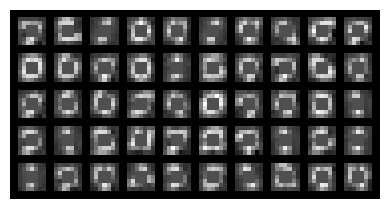

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

pixel y's:


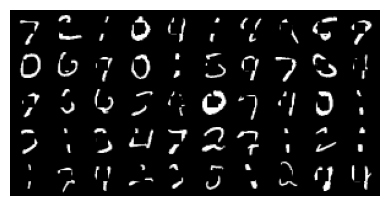

inpainted images:


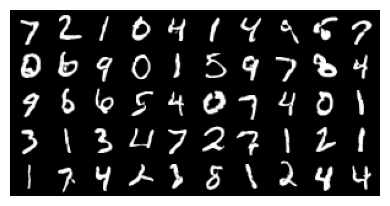

In [ ]:
inpainting_dict ={'decode': None,            # now we're latents-only
                'strength': 1.0,             # "guidance strength", you may vary this
                't_min': 0.2, 't_max': 0.999, # t range to apply guidance, may vary these
                }

# TODO: this code needs to be cleaned up ;-)
@torch.no_grad()
def latents_only_inpaint(sub, inpainting_dict, n_samples: int, n_steps=20, t0=0.2, **kwargs) -> torch.Tensor:
    torch.manual_seed(0) # for reproducibility as we change other things
    zy = sub.encode(y.to(device)) # encoded version of masked image
    # Mz is the shrunk-down version of M
    Mz = F.interpolate(M.unsqueeze(0).unsqueeze(0), size=zy.shape[-2:], mode='bilinear', align_corners=False).to(device)
    Mz = 1.0*(Mz > 0.9)  # make Mz binary
    print("Mask:")
    show_grid(Mz)
    zy = zy* Mz  # enforce mask in latent space.
    inpainting_dict['M_sq'], inpainting_dict['y'] = (Mz**2).to(device), zy
    inpainting_dict['t_min'] = t0
    print("Latent y's:")
    show_grid((zy -zy.min())/(zy.max()-zy.min())) # show masked latents

    z0 = torch.randn_like(zy) * (1-t0) + zy * t0      # interpolation init
    inpainting_dict['t_min'] = t0
    x1 = generate_samples(sub, n_samples=len(y), t0=t0, z0=z0, guidance_dict=inpainting_dict, warp_fn=None, debug=False)
    return x1

inpainting_dict['strength'] = 10.0
x1 = latents_only_inpaint(sub, inpainting_dict, n_samples=len(y), n_steps=20)

print("pixel y's:")
show_grid(y)
print("inpainted images:")
show_grid(x1)

Notice the execution speed!

Now, if we want to enforce the original pixels where the mask is one, we can do that at every stage of the integration process. We just need to modify the integration process to overwrite $z$ wherever `Mz` is 1..



### TODO: next bit with "overwrites" is janky and not explained well at all!

Mask:


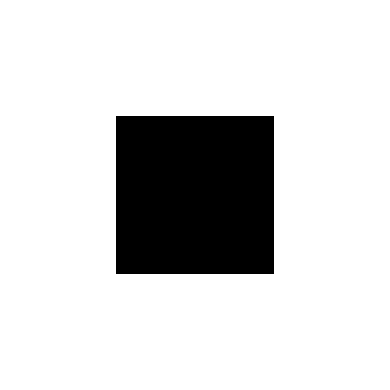

Latent y's:


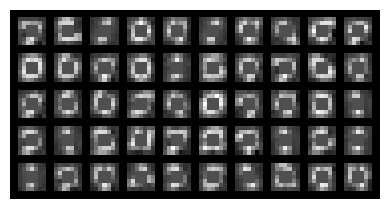

Integrating Path:   0%|          | 0/14 [00:00<?, ?it/s]

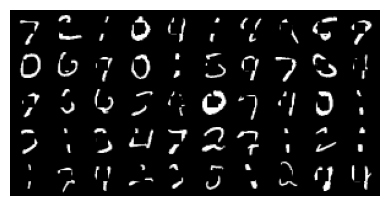

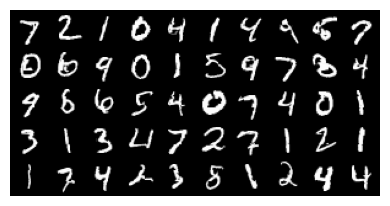

In [ ]:
@torch.no_grad()
def integrate_path(model, initial_points, step_fn=rk4_step, n_steps=10, warp_fn=None, latent_2d=False, prog_bar=True, t0=0, **kwargs):
    p = next(model.parameters())
    device, model_dtype = p.device, p.dtype
    current_points = initial_points.to(device=device, dtype=model_dtype).clone()
    model.eval()
    ts = torch.linspace(t0, 1, n_steps, device=device, dtype=model_dtype)
    if warp_fn: ts = warp_fn(ts)
    if latent_2d: t_batch = torch.empty((current_points.shape[0], 1), device=device, dtype=model_dtype)
    vel_model = partial(compute_v, model)  # here's the secret sauce
    iterator = range(len(ts) - 1)
    if prog_bar: iterator = tqdm(iterator, desc="Integrating Path")
    for i in iterator:
        t, dt = ts[i], ts[i + 1] - ts[i]
        if latent_2d: t = t_batch.fill_(t.item())
        g = kwargs.get('guidance_dict')
        if False and g:
            z, zy, M = current_points, g['y'], g['M_sq']
            zy_interp = torch.randn_like(z)*(1-t) + zy*(t)
            z_over  = M*zy_interp + (1-M)*z   # overwrite w/ zy_interp where M=1
            current_points = (current_points + z_over)/2 # average
        current_points = step_fn(vel_model, current_points, t, dt, **kwargs)
    return current_points



inpainting_dict['strength'] = 10.0
x1 = latents_only_inpaint(sub, inpainting_dict, n_samples=len(y), n_steps=20).cpu()
x1 = M*y + (1-M)*x1.unsqueeze(1) # overwrite

 # show pre- and post-inpainting
show_grid(y.squeeze())
show_grid(x1)

We see that there are some limitations to what's being produced. The problem is due to the low resolution of our latency. In-painting algorithms typically assume higher resolution in order to work accurately.   But this lesson was designed to run quickly on CPUs and thus there is a trade-off.

# IV. Guidance By Any Other Name: PnP-Flow

Some people may want to restrict the use of the term "guidance" to only modifications of the velocity. But this is not the only way to cast the problem in order to achieve the desired result.

A method termed "PnP-Flow" by French researchers Martin et al [4] doesn't modify the velocity but rather adjusts value of the flow "position" variable $z$ (for us, the latents) at each step.[^1]

Yet even "velocity" carries a bit of conventional weight in this case, as our gradient calculation times the strength induces a change in the flow variable, and we only cast it into a "velocity" by dividing or otherwise rescaling by a time-dependent function such as $1/(1-t)$.  

In fact, by adding the "overwriting"of the latent values outside the mask via interpolation, we have already included the key parts of PnP-Flow:
1. compute a gradient based on our constraint,
2. and then overwrite using an interpolated values.

Our variable definitions are a bit different from those in the PnP-Flow paper[^2], so reproducing their equations exactly here won't help. Intead let's set the stage: They *consider only straight-line trajectories* for which the projecting forward via linear extrapolation is *identical* to interating the flow model forward. In other words, the time-integration is *trivial* an thus instead of $\widehat{z_1}$ being a projection from the current latent integration variable $z_t$, we assume that getting $\widehat{z_1}$ is trivial.

In fact the algorithm is best viewed as *starting* $t=0$, moving to our projected estimate $\widehat{z_1}$
and *iterating on that*.  Consequently, it may help to dispense with the picture of integrating our position $z$ incrementially from $t=0$ to 1.  We will still step along those values of $t$, however we will use them to set *step sizes* $(1-t)$ for a series of prediction, correction, and back-projection steps. With that in mind, the first step is that we take our projected estimate $\widehat{z_1}$ and correct it by computing a gradient and move toward our goal:

$${\rm Step\ 1.}\ \ \ \ \ \  \ \ \ \ \ \ z_1^* := \widehat{z_1} - \eta\,\gamma_t \nabla F(\widehat{z_1},y)$$

where $z_1^*$ (my notation) is our goal i.e. the the endpoint of our projected course correction, and $F(\widehat{z_1},y)$ is our (log-exp probability) constraint.  For the time scaling, the PnP-Flow authors recommend $\gamma_t = (1-t)^\alpha$
with $\alpha \in [0,1]$ is a hyperparameter chosen accordint to the task -- e.g., they use $\alpha$'s as large as 0.8 for denoising tasks, 0.5 for box inpainting, and 0.01 for random inpainting. This choice of $\gamma_t$ is a bit different from our earlier one of $(1-t)/t$. Both go to zero as $t \rightarrow 1$, but approach it differently and have different asymtomptotics as as $t\rightarrow 0$.

In the graph below, we show our earlier choice of (1 - t)/t in green, and (1 - t)^α in purple for various choices of α:

In [ ]:
# @title Code for Desmos graph embedding
%%HTML
<iframe src="https://www.desmos.com/calculator/bcp2wiyyid?embed"
width="220" height="300" style="border: 1px solid #ccc" frameborder=0></iframe>

...where for "box inpainting" as we did above, they use $\alpha$=0.5.

But PnP-Flow doesn't stop there!  Two other key steps remain. We then project backward to *overwrite* $z_t$ with a corrected value:

$${\rm Step\ 2.}\ \ \ \ \ \  \ \ \ \  \ \ z_t := (1-t)\,z_0 + t\, z_1^* $$

We then compute a new projected estimate, same as we have before:

$${\rm Step\  3.}\ \ \ \ \ \   \widehat{z_1} := z_t + (1-t)\,v_t(z,t)$$

....and loop over Steps 1 to 3 for each value of $t$ in our set of (discrete) integration steps, i.e. after Step 3, we let $t := t+\Delta\,t$ and go back to Step 1. Our final value of $\widehat{z_1}$ will be the output.

This image from the PnP-Flow paper (slightly re-annotated by me) may provide instructive, showing 3 different instances of the 3 PNP steps:

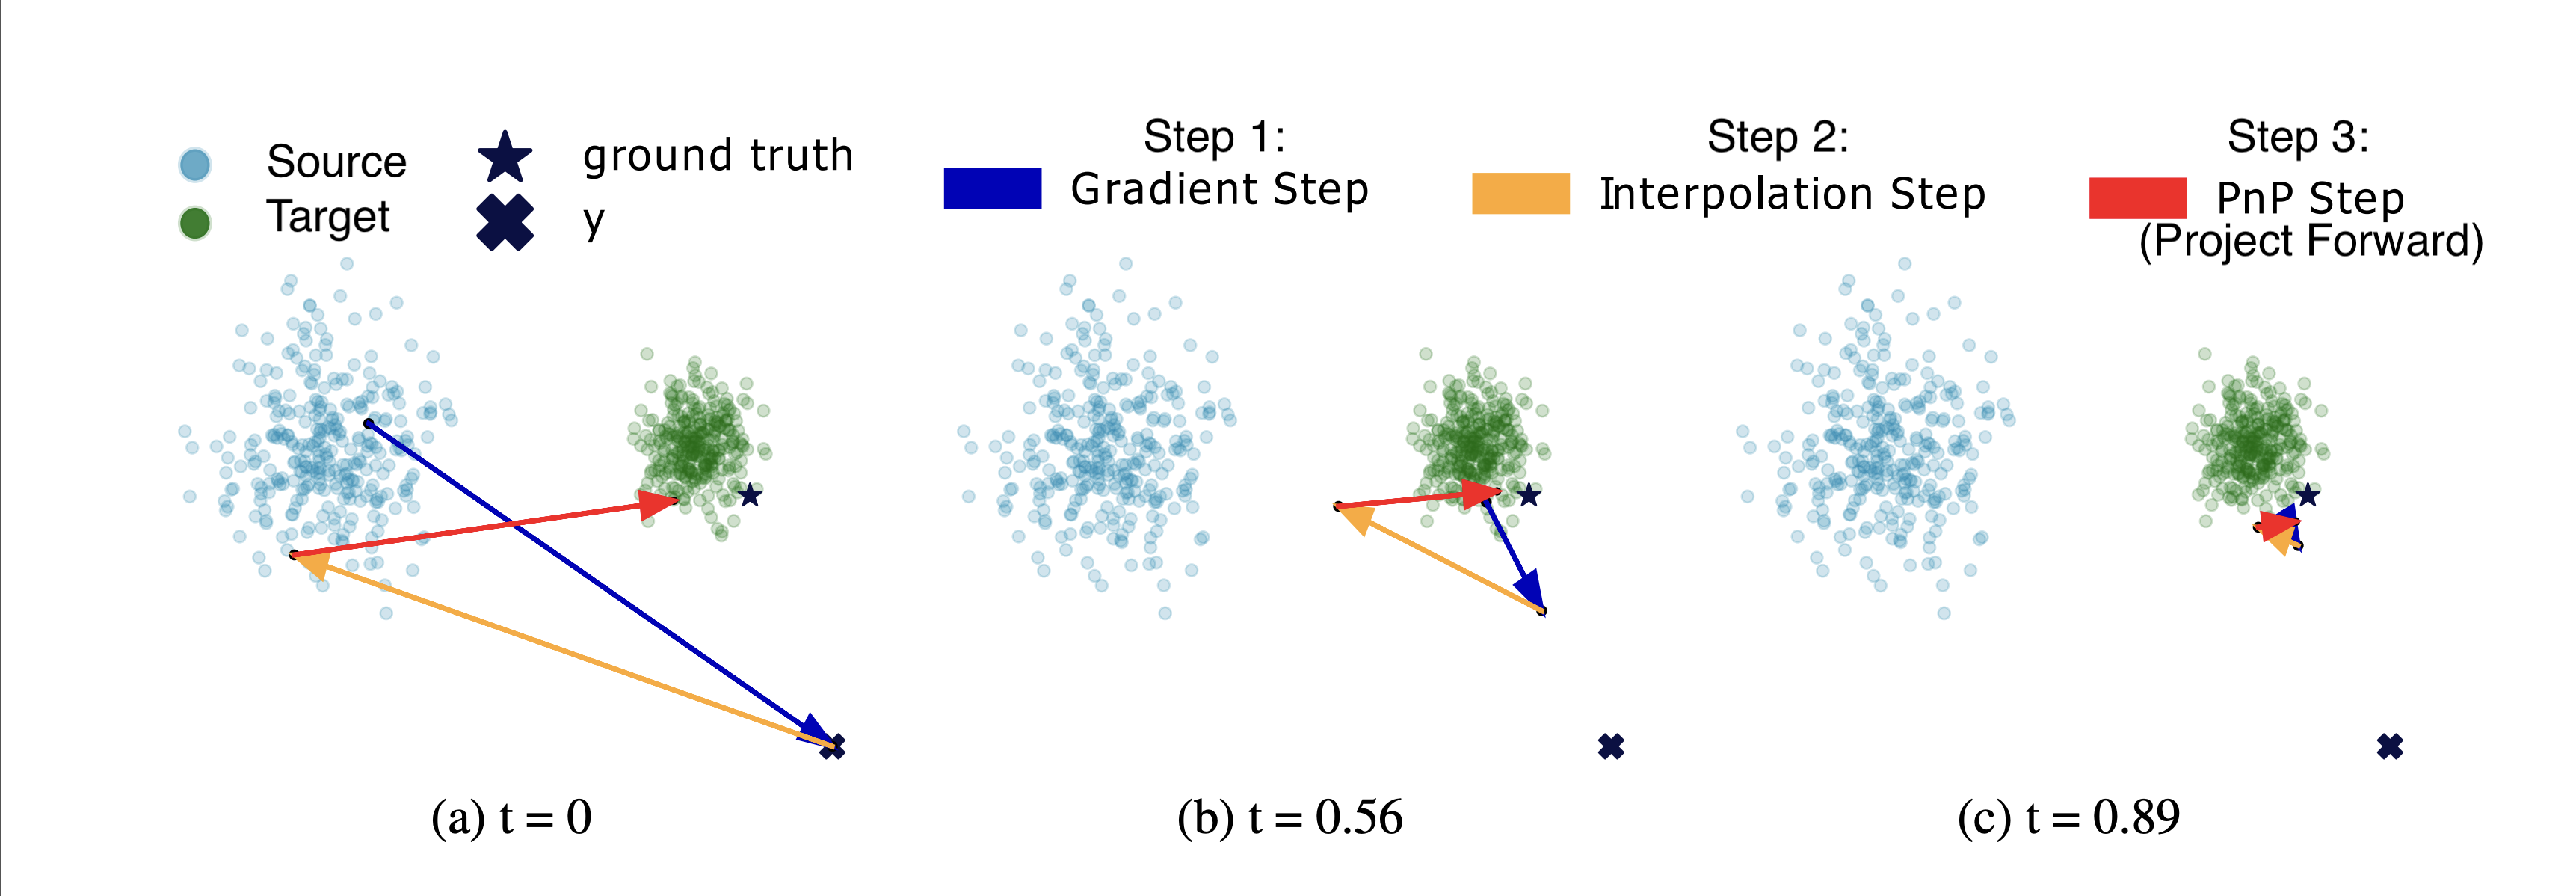

To implement this in code, it's perhaps cleanest if we replace our "integrator" code with soemthing specific to PnP-Flow:

In [ ]:
# call this instead of integrate_path
@torch.no_grad()
def sample_pnpflow(model, z0, n_steps=10, alpha=0.5,  avg_num=5, warp_fn=None, guidance_dict=None, fill_with_y=True):
    "PnP-Flow 'integration' routine"
    assert guidance_dict is not None, "Need guidance_dict to run PnP-Flow"
    g = guidance_dict
    ts = torch.linspace(0, 1, n_steps, device=z0.device, dtype=z0.dtype)
    if warp_fn: ts = warp_fn(ts)
    t=ts[0]
    #z1hat = z0 + (1-t)*model(z0,t)  # "1-step integration" b/c linear path assumption
    z1hat = z0   # actually this fits the PnP-Flow paper/image better and works just as well!
    for i, t in enumerate(ts):
        if i==0: continue # skip it; we already did t=0
        grad = g['M_sq'] * (z1hat - g['y'])     # latents-only inpainting term from earlier
        gamma_t = (1-t)**alpha                        # adaptive time step
        z1star = z1hat - g['strength']*gamma_t*grad   # move to satisfy constraint
        if fill_with_y: z1star = g['M_sq']*g['y'] + (1-g['M_sq'])*z1star   # overwrite with y where M=1

        z1hat_sum = None                          # recommended: average projection over 5 noise estimates
        for j in range(avg_num):
            eps = torch.randn_like(z1star)
            z = (1-t)*eps + t*z1star                       # projection back / interp / overwrite
            z1hat_i = z + (1-t)*model(z,t)                  # "denoiser" / integration
            if z1hat_sum is None: z1hat_sum = z1hat_i
            else: z1hat_sum += z1hat_i
        z1hat = z1hat_sum/avg_num
    return z1hat

The latents-only inpainting model we used earlier was trained to have straight trajectories, so we should be able to use it again here:

Maxed pixel images (y):


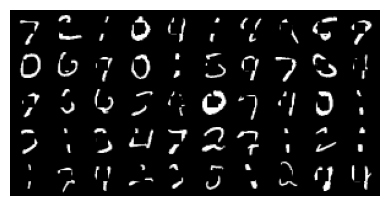


inpainted images, alpha=0.5, strength=1.0, fill_with_y=True:


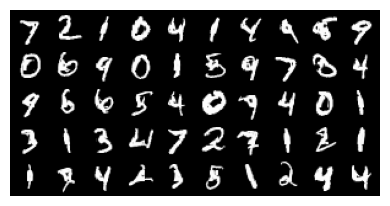


inpainted images, alpha=0.5, strength=1.0, fill_with_y=False:


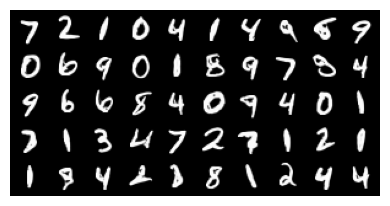

In [ ]:
inpainting_dict ={'decode': None,            # now we're latents-only
                'strength': 1.0,             # "guidance strength", you may vary this
                't_min': 0.0, 't_max': 0.999, # t range to apply guidance, may vary these
                }

# TODO: this code needs to be cleaned up ;-)
@torch.no_grad()
def pnp_flow_inpaint(sub, inpainting_dict, n_samples: int, n_steps=10, t0=0, **kwargs) -> torch.Tensor:
    torch.manual_seed(0) # for reproducibility as we change other things
    zy = sub.encode(y.to(device)) # encoded version of masked image
    # Mz is the shrunk-down version of M
    Mz = F.interpolate(M.unsqueeze(0).unsqueeze(0), size=zy.shape[-2:], mode='bilinear', align_corners=False)
    Mz = 1.0*(Mz > 0.9).to(device)  # make Mz binary
    zy = zy* Mz  # enforce mask in latent space.
    #print("Latent y's:")
    #show_grid((zy -zy.min())/(zy.max()-zy.min()))
    inpainting_dict['M_sq'], inpainting_dict['y'] = Mz**2, zy
    inpainting_dict['t_min'] = t0
    z0 = torch.randn_like(zy) * (1-t0) + zy * t0      # interpolation init
    inpainting_dict['t_min'] = t0
    z1 = sample_pnpflow(sub.flow_model, z0, guidance_dict=inpainting_dict, warp_fn=None, **kwargs)
    return z1


print(f"Maxed pixel images (y):")
show_grid(y)

# Tried looping over hyperparams, ended up with those below
# for inpainting_dict['strength'] in [0.5, 1.0, 4.0]:
#     for alpha in [0.1, 0.5, 0.8, 1.0]:

inpainting_dict['strength'] = 1.0
alpha = 0.5
for fill_with_y in [True, False]:
    z1 = pnp_flow_inpaint(sub, inpainting_dict, n_samples=len(y), n_steps=20, alpha=alpha, fill_with_y=fill_with_y)
    x1 = F.sigmoid(sub.decode(z1)).cpu()
    if fill_with_y: x1 = M*y + (1-M)*x1
    #print(f"Latent z1's, alpha={alpha}:")
    #show_grid((z1 -z1.min())/(z1.max()-z1.min()))
    print(f"\ninpainted images, alpha={alpha}, strength={inpainting_dict['strength']}, fill_with_y={fill_with_y}:")
    show_grid(x1)

...So this *kind of* works, but it also seems to "take some liberties." This could be because of the low spatial resolution of the latents, e.g. that they are encoding information about curvature.

## Exercise:
1. Investigate the results of varying the hyperparameters `alpha` and the strength.


Footnotes:

[^1]: The paper by Pokle et al we cited earlier also included a related method, however the PnP-Flow method is a bit more general and the PnP-Flow paper is *much* more readable than Pokle et al. ;-) Plus, Anne Gagneux provided [code](https://github.com/annegnx/PnP-Flow) for PnP-Flow!  Gangeux's repo even provides code for the position-only (non-velocity) algorithm from Pokle et al aka "OT-ODE".


[^2]: Differences between our variables and those in the PnP-Flow paper: For us, $z$ are integrated flow latent variables between $z_0$ (source) and $z_1$ (target), whereas $x$ are the pixel-space representations via our VAE's decoder $\mathscr{D}$ such that $\mathscr{D}(z)=x$. In PnP-Flow, $x$ is the integrated flow  variable, $z$ is used only for their interpolation/overwrite step, and $\mathscr{D}$ is the "denoiser" aka their flow model.


## TODO: add more on PnP-Flow...


# Summary

TODO.

# References

TODO: fill this in better

1. Hawley, "Flow With What You Know", ICLR 2025 Blogpost Track, https://iclr-blogposts.github.io/2025/blog/flow-with-what-you-know/
2. Dieleman, "Guidance: a cheat code for diffusion models," May 2022, https://sander.ai/2022/05/26/guidance.html
3. Pokle et al, "Training-free Linear Image Inverses via Flows," ICLR 2024, https://openreview.net/forum?id=3JoQqW35GQ
4. Martin et al, "PnP-Flow: Plug-and-Play Image Restoration with Flow Matching," https://arxiv.org/abs/2410.02423.  [GitHub](https://github.com/annegnx/PnP-Flow)
5. Ye et al, "TFG: Unified Training-Free Guidance for Diffusion Models," NeurIPS 2024, [arXiv:2409.15761](https://arxiv.org/abs/2409.15761), [GitHub](https://github.com/YWolfeee/Training-Free-Guidance)
6. Daras et al, "A Survey on Diffusion Models for Inverse Problems", https://arxiv.org/abs/2410.00083v1
7. Blasingame & Liu, "Greed is Good: A Unifying Perspective on Guided Generation," https://arxiv.org/abs/2502.08006